In [ ]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
from noise2seg.models import Noise2Seg, Noise2SegConfig
import numpy as np
from csbdeep.utils import plot_history
from noise2seg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from noise2seg.utils.seg_utils import *
from noise2seg.utils.compute_precision_threshold import compute_threshold, precision
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy import ndimage
import tensorflow as tf
import keras.backend as K
import urllib
import os
import zipfile

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/DSB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/LIN4L4R9b2gebDX/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
trainval_data =  np.load('data/DSB/train_data/dsb2018_TrainVal40.npz')
test_data =  np.load('data/DSB/test_data/dsb2018_Test40.npz', allow_pickle=True)
train_images = trainval_data['X_train']
val_images = trainval_data['X_val']
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (3800, 128, 128) , Shape of train_masks:  (3800, 128, 128)
Shape of val_images:  (670, 128, 128) , Shape of val_masks:  (670, 128, 128)
Shape of test_images:  (50,) , Shape of test_masks:  (50,)


In [5]:
fraction = 0.25 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"

X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed = random_seed)
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = augment_data(val_images, val_masks)

Training Data 
..................
Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)


Validation Data 
..................
Raw image size after augmentation (5360, 128, 128)
Mask size after augmentation (5360, 128, 128)


In [6]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of train images: ", X.shape, ", Shape of train masks: ", Y.shape)
print("Shape of validation images: ", X_val.shape, ", Shape of validation masks: ", Y_val.shape)

Shape of train images:  (30400, 128, 128, 1) , Shape of train masks:  (30400, 128, 128, 3)
Shape of validation images:  (5360, 128, 128, 1) , Shape of validation masks:  (5360, 128, 128, 3)


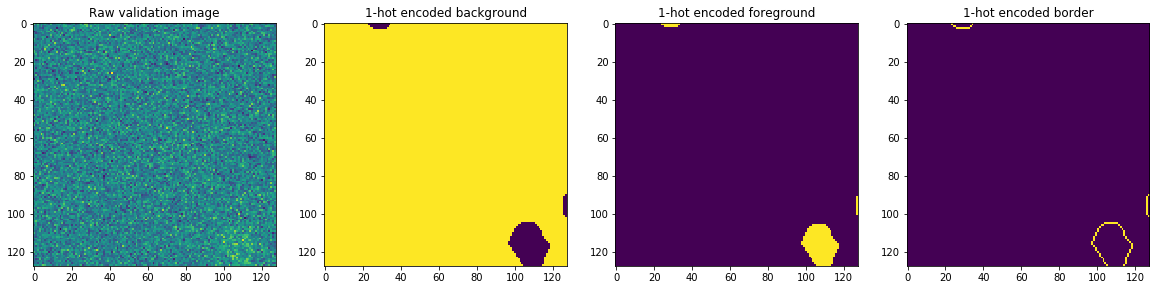

In [7]:
sl = 1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

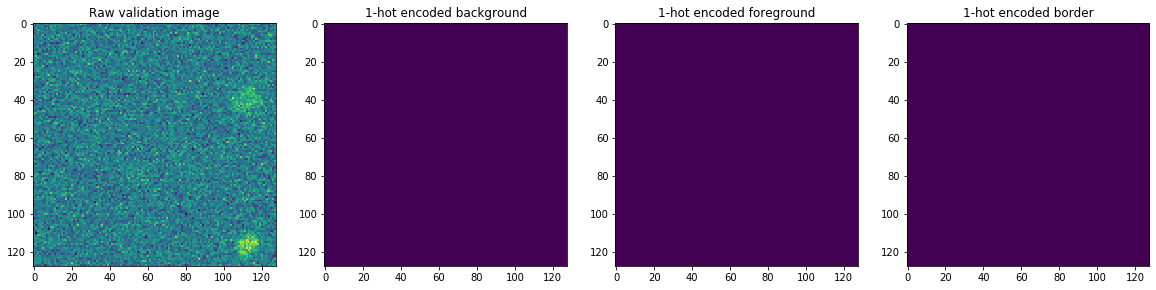

In [8]:
sl = -1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

In [9]:
n2s_conf = Noise2SegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                   train_steps_per_epoch=400, train_epochs=50, train_loss='noise2seg', batch_norm=True, 
                   train_batch_size=128, unet_n_first = 32, unet_n_depth=4, n2s_lambda=0.5,
                          train_tensorboard=False)

vars(n2s_conf)

{'means': ['13.486056681163625'],
 'stds': ['44.00658058465437'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'noise2seg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 50,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2s_lambda': 0.5}

# <div style='color:red'>Tensorboard is not working!</div>

In [10]:
model_name = 'noise2seg_0.25_srv1_lambda=1:1'
basedir = 'models'
n2s_model = Noise2Seg(n2s_conf, model_name, basedir)

In [11]:
history = n2s_model.train(X, Y, (X_val, Y_val))


61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 5360/5360 [00:37<00:00, 144.11it/s]




Epoch 1/50
400/400 [==============================] - 126s 316ms/step - loss: 0.8576 - noise2seg: 0.8576 - val_loss: 1.7699 - val_noise2seg: 1.7699
Epoch 2/50
400/400 [==============================] - 118s 294ms/step - loss: 0.8406 - noise2seg: 0.8406 - val_loss: 1.5811 - val_noise2seg: 1.5811
Epoch 3/50
400/400 [==============================] - 113s 281ms/step - loss: 0.8383 - noise2seg: 0.8383 - val_loss: 1.4222 - val_noise2seg: 1.4222
Epoch 4/50
400/400 [==============================] - 115s 287ms/step - loss: 0.8383 - noise2seg: 0.8383 - val_loss: 1.3525 - val_noise2seg: 1.3525
Epoch 5/50
400/400 [==============================] - 115s 286ms/step - loss: 0.8360 - noise2seg: 0.8360 - val_loss: 1.2839 - val_noise2seg: 1.2839
Epoch 6/50
400/400 [==============================] - 116s 290ms/step - loss: 0.8375 - noise2seg: 0.8375 - val_loss: 1.2650 - val_noise2seg: 1.2650
Epoch 7/50
400/400 [==============================] - 114s 284ms/step - loss: 0.8366 - noise2seg: 0.8366 - val

In [12]:
history.history.keys()

dict_keys(['val_loss', 'val_noise2seg', 'loss', 'noise2seg', 'lr'])

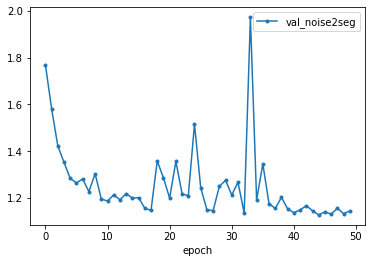

In [13]:
plot_history(history, ['val_noise2seg'])

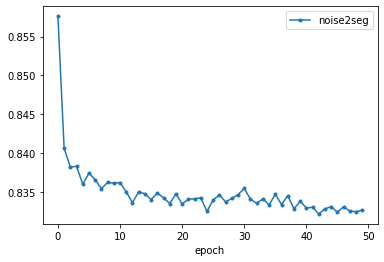

In [14]:
plot_history(history, ['noise2seg'])

In [20]:
model_name = 'noise2seg_0.25_srv1_lambda=1:1'
basedir = 'models'
n2s_model = Noise2Seg(None, model_name, basedir)

Loading network weights from 'weights_best.h5'.


In [21]:
threshold = n2s_model.optimize_thresholds(val_images.astype(np.float32), val_masks)

Computing best threshold: 


Precision-Score for threshold = 0.10 is 0.5916
Precision-Score for threshold = 0.15 is 0.6222
Precision-Score for threshold = 0.20 is 0.6249
Precision-Score for threshold = 0.25 is 0.6288
Precision-Score for threshold = 0.30 is 0.6220
Precision-Score for threshold = 0.35 is 0.6136
Precision-Score for threshold = 0.40 is 0.6091
Precision-Score for threshold = 0.45 is 0.5930
Precision-Score for threshold = 0.50 is 0.5750
Precision-Score for threshold = 0.55 is 0.5516
Precision-Score for threshold = 0.60 is 0.5263
Precision-Score for threshold = 0.65 is 0.5012
Precision-Score for threshold = 0.70 is 0.4702
Precision-Score for threshold = 0.75 is 0.4328
Precision-Score for threshold = 0.80 is 0.3752
Precision-Score for threshold = 0.85 is 0.3107
Precision-Score for threshold = 0.90 is 0.2170
Precision-Score for threshold = 0.95 is 0.0987
Precision-Score for threshold = 1.00 is 0.0000



In [ ]:
from noise2seg.utils.compute_precision_threshold import 

In [22]:
predicted_images, precision_result = n2s_model.predict_label_masks(test_images, test_masks, threshold, )
print("Average precision over all test images at IOU = {}: ".format(threshold), precision_result)

TypeError: predict_label_masks() missing 1 required positional argument: 'measure'